In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("zalando-research/fashionmnist")

print("Path to dataset files:", path)

/home/rahovegas/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: /home/rahovegas/.cache/kagglehub/datasets/zalando-research/fashionmnist/versions/4


In [2]:
import numpy as np
import pandas as pd
import os
import pickle

%matplotlib inline
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold, SelectPercentile, chi2
from sklearn.model_selection import train_test_split

from skimage.transform import resize
from skimage.feature import hog

In [3]:
train_path = path + "/fashion-mnist_train.csv"
test_path = path + "/fashion-mnist_test.csv"

train_data = pd.read_csv(train_path)
test_data = pd.read_csv(test_path)

(train_imgs, train_labels) = (train_data.iloc[:, 1:].values.reshape(-1, 28, 28).astype('uint8'), train_data.iloc[:, 0].values)

(test_imgs, test_labels) = (test_data.iloc[:, 1:].values.reshape(-1, 28, 28).astype('uint8'), test_data.iloc[:, 0].values)

Labels: [0 1 2 3 4 5 6 7 8 9]


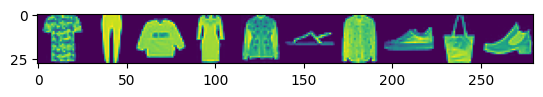

In [4]:
show_idxs = [np.where(train_labels == i)[0][0] for i in range(10)]
show_imgs = np.concatenate(tuple(train_imgs[idx,:,:] for idx in show_idxs), axis=1)
plt.imshow(show_imgs)

print("Labels:", train_labels[show_idxs])

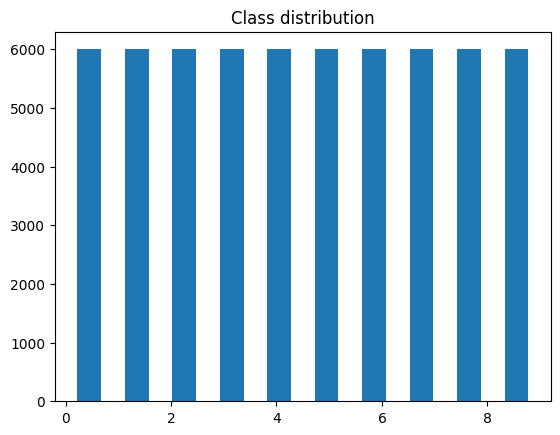

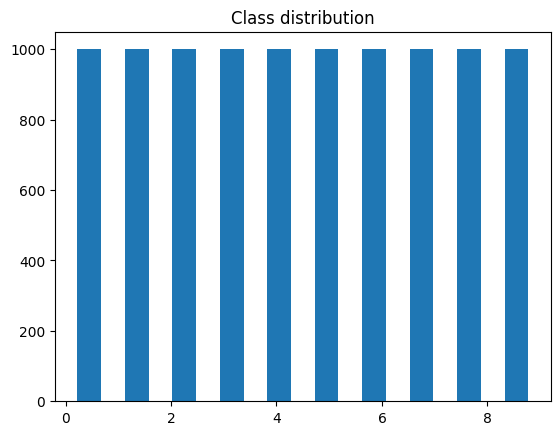

In [5]:
def plot_class_distribution(labels):
	plt.title('Class distribution')
	plt.hist(labels, bins=10, rwidth=0.5)
	plt.show()

plot_class_distribution(train_labels)
plot_class_distribution(test_labels)

In [6]:
class DataProcessing:
	def __init__(self, train_data, test_data):
		self.train_data = train_data
		self.test_data = test_data

	def extract_PCA_features(self, imgs, n_components):
		scaler = StandardScaler()
		flatten_imgs = scaler.fit_transform([i.flatten() for i in imgs])
		pca = PCA(n_components=n_components)
		
		principal_components = pca.fit_transform(flatten_imgs)
		imgs_reduced = pca.inverse_transform(principal_components).reshape(-1, 28, 28)
		
		return principal_components, imgs_reduced
	
	def show_PCA(self, img, img_reduced, n_components):
		fig = plt.figure(figsize=(5, 5))
		ax1 = fig.add_subplot(1, 2, 1)
		ax1.axis('off')
		ax1.set_title('Original Image')
		plt.imshow(img)

		ax1 = fig.add_subplot(1, 2, 2)
		ax1.axis('off')
		ax1.set_title('{} PC'.format(n_components))
		plt.imshow(img_reduced)

		plt.show()

	def show_PCA_all_classes(self, imgs, imgs_reduced, n_components):
		for idx in show_idxs:
			self.show_PCA(imgs[idx,:,:], imgs_reduced[idx,:,:], n_components)

	def show_PCA_variance(self, imgs):
		scaler = StandardScaler()
		flatten_imgs = scaler.fit_transform([i.flatten() for i in imgs])

		cov_matrix = np.dot(flatten_imgs, flatten_imgs.T)
		eigval, eigvect = np.linalg.eig(cov_matrix)

		index = np.argsort(eigval)[::-1]

		eigvect = eigvect[:,index]
		eigval = eigval[index]

		var_tmp = 0
		n_PC = []
		var_explained = []
		var_temp = []

		for i in range(20):
			var_tmp = var_tmp + eigval[i]
			n_PC.append(i)
			var_temp.append(eigval[i]/(eigval.sum()) * 100)
			var_explained.append(var_tmp/(eigval.sum()) * 100)
		
		fig, ax = plt.subplots(figsize=(8,8))

		ind = np.arange(20)
		width = 0.35
		p1 = ax.bar(ind, var_temp, width, color='b')
		p2 = ax.bar(ind + width, var_explained, width, color='r')

		ax.legend((p1[0],p2[0]), ('Individual explained variance', 'Cummulative explained variance'))

		ax.set_title('Variance explained using PCs')
		ax.set_xticks(ind + width / 2)
		ax.set_xticklabels(('1', '2', '3', '4', '5', '6', '7', '8', '9', '10',
							'11', '12', '13', '14', '15', '16', '17', '18', '19', '20'))

		plt.xlabel('Number of PCs')
		plt.ylabel('Variance explained in %')

		ax.autoscale_view()
		
		plt.show()
	
	def extract_HOG_features(self, imgs, hog_path, n_bins=9):
		if os.path.exists(hog_path):
			return pickle.load(open(hog_path + '/hog_features.pkl', 'rb'))
		
		os.makedirs(hog_path)

		fds = []

		idx = 0

		for img in imgs:
			img_resized = resize(img, (128, 64))
			fd, hog_img = hog(img_resized, orientations=n_bins, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True)
			hog_img = resize(hog_img, (28, 28))
			
			pickle.dump(hog_img, open(hog_path + '/hog_img_{}.pkl'.format(idx), 'wb'))
			fds.append(fd)

			idx += 1

		pickle.dump(fds, open(hog_path + '/hog_features.pkl', 'wb'))
		
		return np.array(fds)
		
	def show_HOG(self, img, hog_features, n_bins):
		fig = plt.figure(figsize=(5, 5))

		ax1 = fig.add_subplot(1, 2, 1)
		ax1.axis('off')
		ax1.set_title('Original Image')
		plt.imshow(img)

		ax1 = fig.add_subplot(1, 2, 2)
		ax1.axis('off')
		ax1.set_title('HOG')
		plt.imshow(hog_features, cmap='gray')

		plt.show()

	def show_HOG_all_classes(self, imgs, n_bins):
		for idx in show_idxs:
			hog_feature = pickle.load(open('./hog_train/hog_img_{}.pkl'.format(idx), 'rb'))
			self.show_HOG(imgs[idx,:,:], hog_feature, n_bins)

	def collect_and_transform_data(self):
		scaler = StandardScaler()

		train_pca, train_pca_reduced = self.extract_PCA_features(train_imgs, 20)
		self.show_PCA_all_classes(train_imgs, train_pca_reduced, 20)
		self.show_PCA_variance(train_imgs[:1000])
		
		test_pca, test_pca_reduced = self.extract_PCA_features(test_imgs, 20)

		train_hog = self.extract_HOG_features(train_imgs, './hog_train')
		self.show_HOG_all_classes(train_imgs, 9)

		test_hog = self.extract_HOG_features(test_imgs, './hog_test')

		X_train = np.concatenate((train_pca, train_hog), axis=1)
		X_test = np.concatenate((test_pca, test_hog), axis=1)

		print("Number of extracted features after PCA and HOG:", X_train.shape[1])

		sel = VarianceThreshold(threshold=.95 * (1 - .95))
		X_train = sel.fit_transform(X_train)
		X_test = sel.transform(X_test)

		X_train = scaler.fit_transform(X_train)
		X_test = scaler.transform(X_test)

		print("Number of extracted features after variance threshold:", X_train.shape[1])

		return X_train, X_test, train_labels, test_labels

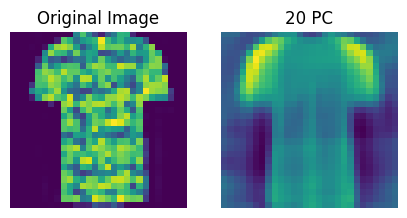

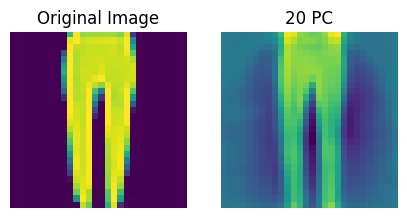

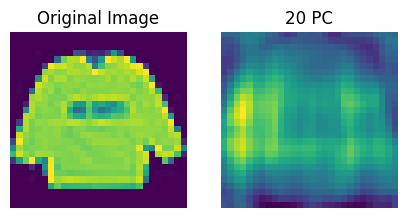

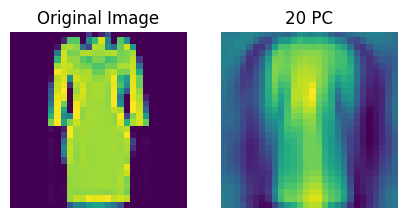

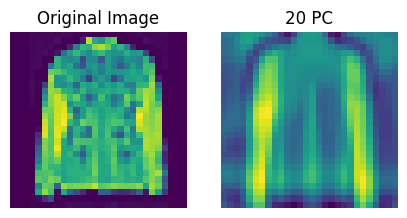

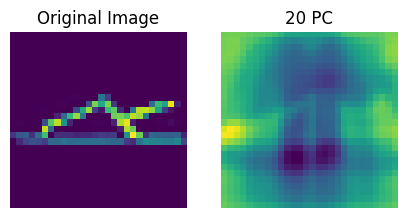

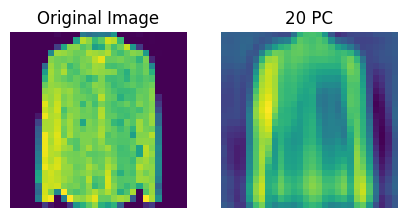

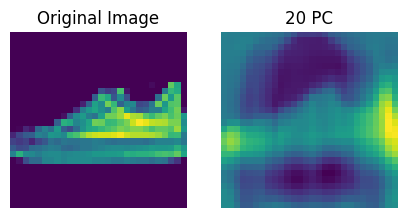

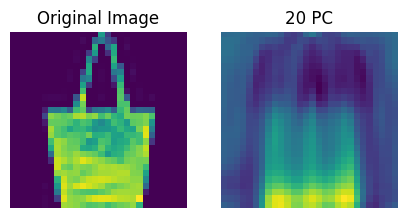

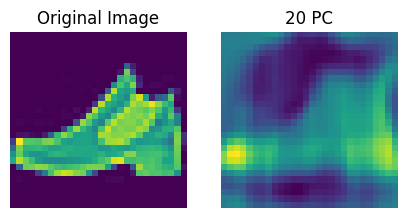

/home/rahovegas/.local/lib/python3.10/site-packages/matplotlib/transforms.py:762: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)


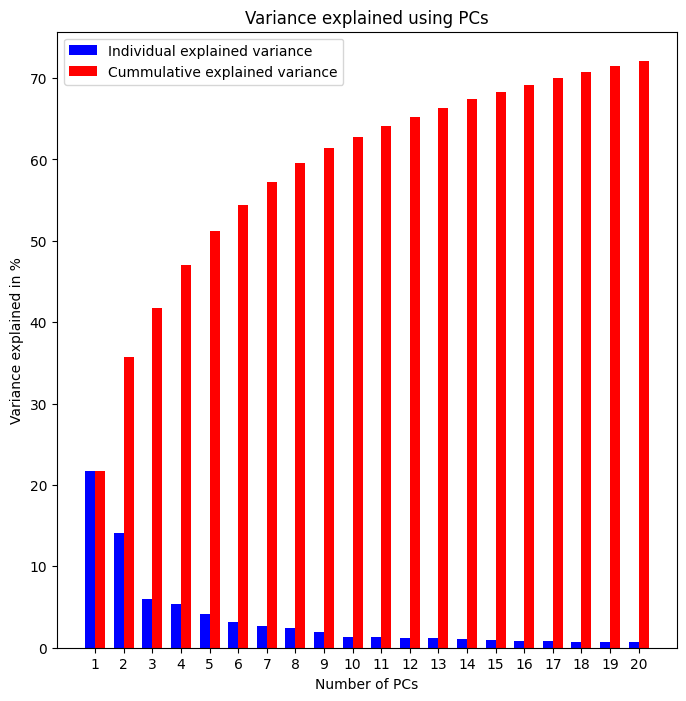

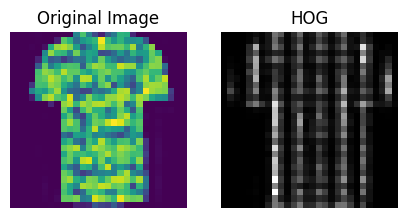

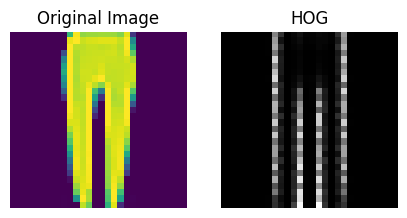

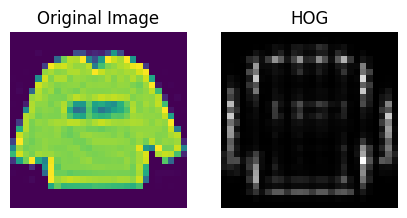

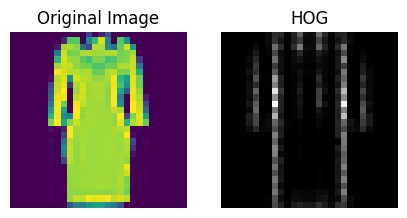

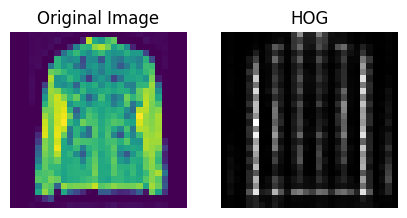

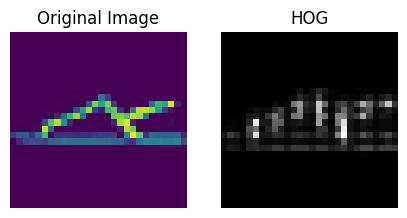

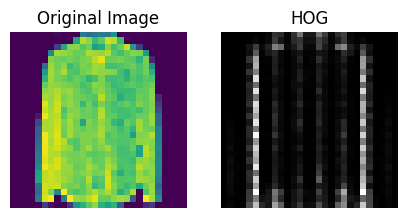

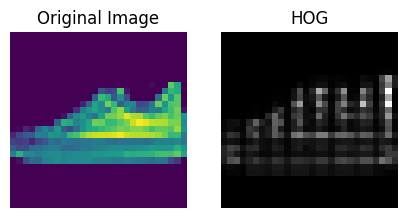

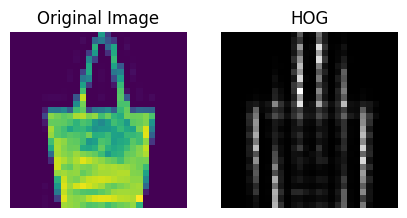

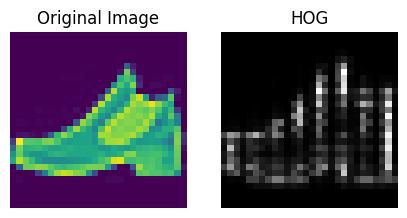

Number of extracted features after PCA and HOG: 3800
Number of extracted features after variance threshold: 119


In [7]:
X_train, X_test, y_train, y_test = DataProcessing(train_imgs, test_imgs).collect_and_transform_data()
X_train, X_validate, y_train, y_validate = train_test_split(X_train, y_train, test_size=0.2, shuffle=True, random_state=42)

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay

import xgboost as xgb

import seaborn as sns

Statistics for validation set - Logistic Regression
              precision    recall  f1-score   support

           0       0.79      0.82      0.81      1232
           1       0.97      0.96      0.97      1174
           2       0.76      0.75      0.75      1200
           3       0.82      0.85      0.84      1242
           4       0.71      0.77      0.74      1185
           5       0.90      0.91      0.91      1141
           6       0.66      0.55      0.60      1243
           7       0.90      0.90      0.90      1224
           8       0.94      0.95      0.95      1149
           9       0.94      0.93      0.93      1210

    accuracy                           0.84     12000
   macro avg       0.84      0.84      0.84     12000
weighted avg       0.84      0.84      0.84     12000



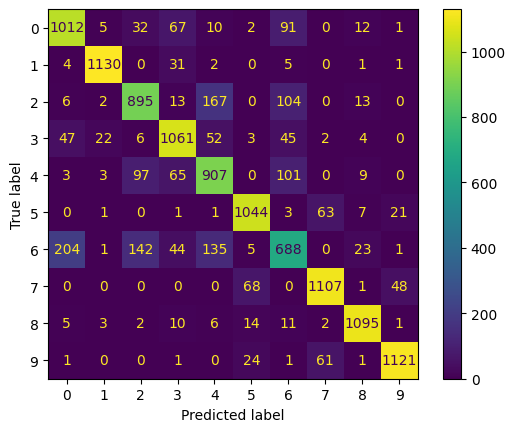

In [9]:
clf_lr = LogisticRegression(penalty='l2', C=0.8, multi_class='ovr', random_state=0, max_iter=500).fit(X_train, y_train)
y_pred = clf_lr.predict(X_validate)

print("Statistics for validation set - Logistic Regression")
print(classification_report(y_validate, y_pred))
ConfusionMatrixDisplay.from_predictions(y_validate, y_pred)

Statistics for validation set - SVM
              precision    recall  f1-score   support

           0       0.82      0.86      0.84      1232
           1       0.99      0.95      0.97      1174
           2       0.82      0.81      0.81      1200
           3       0.85      0.91      0.88      1242
           4       0.77      0.82      0.80      1185
           5       0.94      0.94      0.94      1141
           6       0.72      0.63      0.67      1243
           7       0.91      0.93      0.92      1224
           8       0.97      0.97      0.97      1149
           9       0.95      0.94      0.95      1210

    accuracy                           0.87     12000
   macro avg       0.87      0.87      0.87     12000
weighted avg       0.87      0.87      0.87     12000



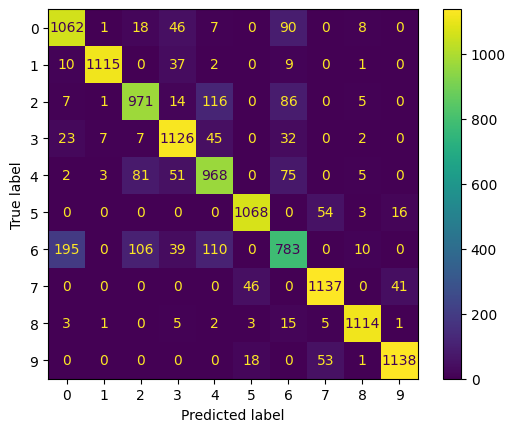

In [10]:
clf_svm = SVC(C=0.6, kernel='rbf', gamma='auto', random_state=0).fit(X_train, y_train)
y_pred = clf_svm.predict(X_validate)

print("Statistics for validation set - SVM")
print(classification_report(y_validate, y_pred))
ConfusionMatrixDisplay.from_predictions(y_validate, y_pred)

Statistics for validation set - Random Forest
              precision    recall  f1-score   support

           0       0.81      0.84      0.83      1232
           1       0.99      0.93      0.96      1174
           2       0.77      0.79      0.78      1200
           3       0.81      0.90      0.85      1242
           4       0.74      0.77      0.76      1185
           5       0.93      0.92      0.92      1141
           6       0.69      0.57      0.63      1243
           7       0.91      0.90      0.90      1224
           8       0.93      0.96      0.94      1149
           9       0.93      0.94      0.94      1210

    accuracy                           0.85     12000
   macro avg       0.85      0.85      0.85     12000
weighted avg       0.85      0.85      0.85     12000



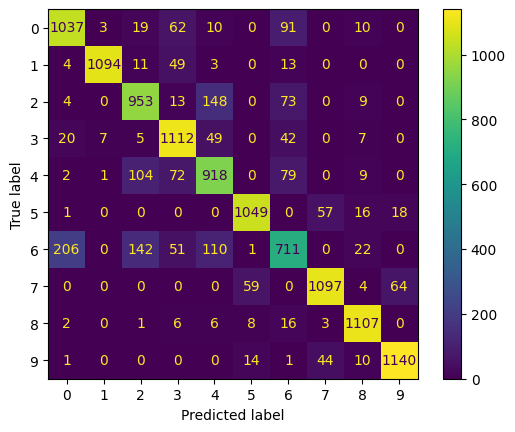

In [11]:
clf_rf = RandomForestClassifier(n_estimators=100, max_depth=20, random_state=0, max_samples=10000, bootstrap=True).fit(X_train, y_train)
y_pred = clf_rf.predict(X_validate)

print("Statistics for validation set - Random Forest")
print(classification_report(y_validate, y_pred))
ConfusionMatrixDisplay.from_predictions(y_validate, y_pred)

Statistics for validation set - XGBoost
              precision    recall  f1-score   support

           0       0.80      0.84      0.82      1232
           1       0.98      0.95      0.96      1174
           2       0.77      0.77      0.77      1200
           3       0.84      0.89      0.86      1242
           4       0.73      0.77      0.75      1185
           5       0.91      0.91      0.91      1141
           6       0.67      0.58      0.62      1243
           7       0.90      0.90      0.90      1224
           8       0.95      0.95      0.95      1149
           9       0.93      0.94      0.93      1210

    accuracy                           0.85     12000
   macro avg       0.85      0.85      0.85     12000
weighted avg       0.85      0.85      0.85     12000



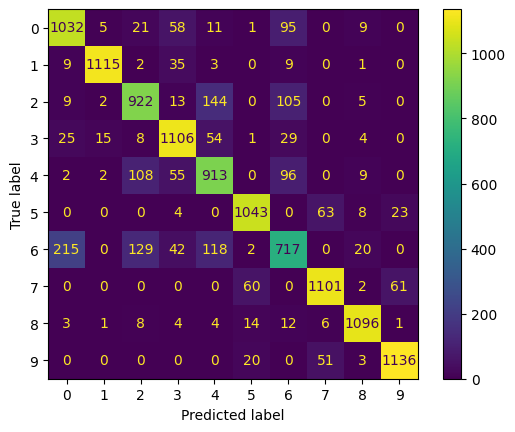

In [12]:
clf_xgb = xgb.XGBClassifier(n_estimators=100, max_depth=20, learning_rate=0.003, random_state=0).fit(X_train, y_train)
y_pred = clf_xgb.predict(X_validate)

print("Statistics for validation set - XGBoost")
print(classification_report(y_validate, y_pred))
ConfusionMatrixDisplay.from_predictions(y_validate, y_pred)

Statistics for test set - Logistic Regression
              precision    recall  f1-score   support

           0       0.78      0.81      0.79      1000
           1       0.96      0.93      0.95      1000
           2       0.71      0.69      0.70      1000
           3       0.73      0.86      0.79      1000
           4       0.69      0.59      0.64      1000
           5       0.89      0.82      0.85      1000
           6       0.64      0.57      0.61      1000
           7       0.79      0.93      0.86      1000
           8       0.90      0.95      0.93      1000
           9       0.91      0.84      0.87      1000

    accuracy                           0.80     10000
   macro avg       0.80      0.80      0.80     10000
weighted avg       0.80      0.80      0.80     10000

Statistics for test set - SVM
              precision    recall  f1-score   support

           0       0.81      0.84      0.83      1000
           1       0.99      0.93      0.96      1000
  

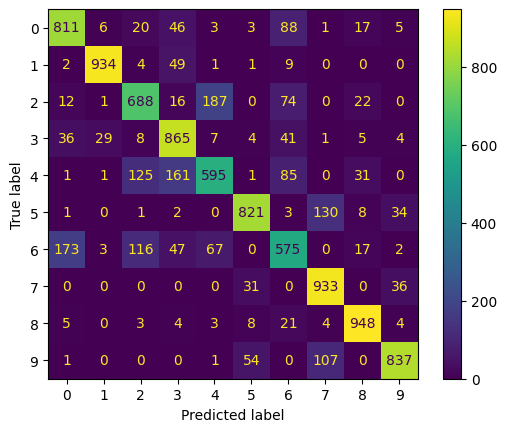

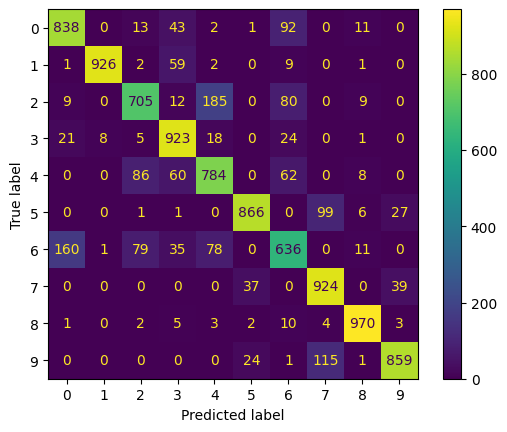

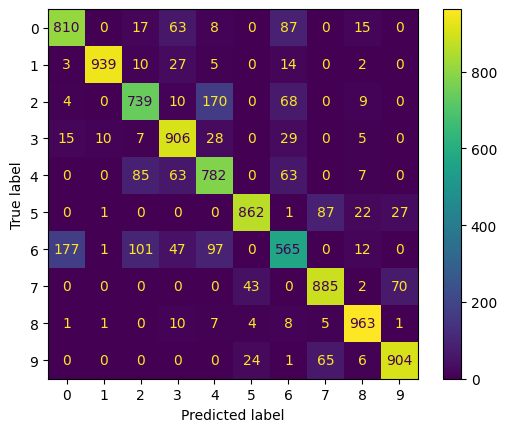

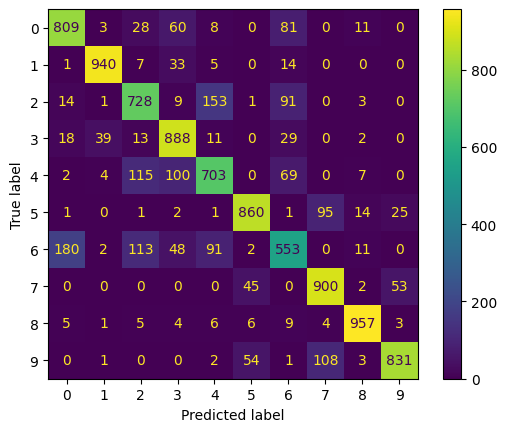

In [13]:
y_pred = clf_lr.predict(X_test)

print("Statistics for test set - Logistic Regression")
print(classification_report(y_test, y_pred))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

y_pred = clf_svm.predict(X_test)

print("Statistics for test set - SVM")
print(classification_report(y_test, y_pred))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

y_pred = clf_rf.predict(X_test)

print("Statistics for test set - Random Forest")
print(classification_report(y_test, y_pred))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

y_pred = clf_xgb.predict(X_test)

print("Statistics for test set - XGBoost")
print(classification_report(y_test, y_pred))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)